In [1]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *

import shutil
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

pd.set_option("max_colwidth", 100)
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

from google.cloud import storage

In [2]:
%%time

path = 'gs://msca-bdp-students-bucket/shared_data/kaihayden/final2'

tweets_df = spark.read.parquet(path)

CPU times: user 4.5 ms, sys: 95 µs, total: 4.59 ms
Wall time: 6.13 s


In [3]:
tweets_df.columns

['dt_date',
 'dt_datehour',
 'dt_day',
 'dt_hour',
 'dt_month',
 'dt_year',
 'ext_qt_user_id',
 'ext_rp_user_id',
 'ext_rt_id',
 'ext_rt_user_id',
 'is_original',
 'twt_continent',
 'twt_hashtags',
 'twt_id',
 'twt_importance',
 'twt_likes',
 'twt_quote_count',
 'twt_reply_count',
 'twt_retwt_count',
 'twt_text',
 'usr_desc',
 'usr_followers',
 'usr_id',
 'usr_location',
 'usr_name',
 'usr_tweet_count',
 'usr_verified']

In [4]:
tweets_df_o = tweets_df.filter(col('is_original')==1)

In [10]:
tweet_location = tweets_df.groupBy('twt_continent').count()

In [11]:
tweet_location_o = tweets_df_o.groupBy('twt_continent').count()

In [22]:
tweet_location_pd = tweet_location.toPandas()

In [13]:
tweet_location_o_pd = tweet_location_o.toPandas()

In [24]:
tweet_location_pd = tweet_location_pd.drop(index=1)

In [28]:
tweet_location_o_pd = tweet_location_o_pd.drop(index=1)

In [31]:
tweet_location_pd.set_index('twt_continent')

,count
twt_continent,
NA,4649366
SA,62610
AS,788013
OC,399066
EU,2081747
AF,330993


In [32]:
tweet_location_o_pd.set_index('twt_continent')

,count
twt_continent,
NA,639161
SA,5327
AS,174318
OC,59594
EU,233655
AF,53014


<ipython-input-51-25d93d124b16>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])


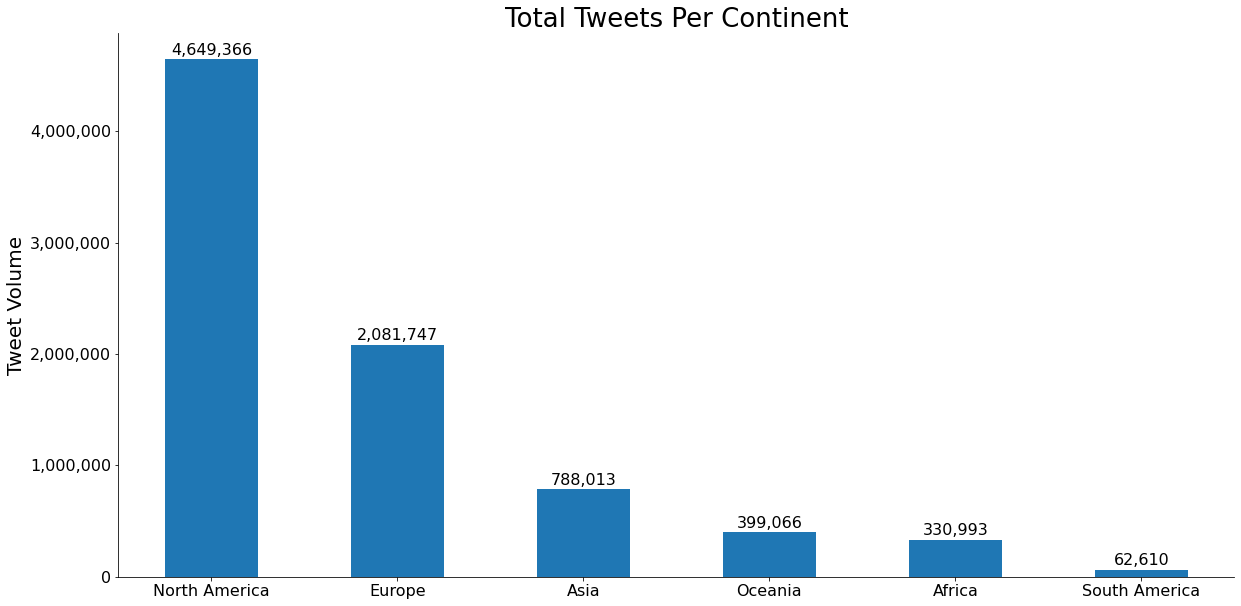

In [51]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

tweet_location_pd.sort_values(by='count',ascending=False).plot.bar(ax=ax,legend=None)

r_side = ax.spines["right"]
r_side.set_visible(False)
t_side = ax.spines["top"]
t_side.set_visible(False)

ax.tick_params(axis='x', rotation=0)

ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_ylabel("Tweet Volume", fontsize=20)

ax.set_xticklabels(['North America','Europe','Asia','Oceania','Africa','South America'])

ax.set_title('Total Tweets Per Continent', fontsize=26)

for p in ax.patches:
       ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', fontsize=16,
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])
        
plt.savefig('./graph6.png',bbox_inches='tight')
plt.show()

<ipython-input-52-a0457d411b89>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])


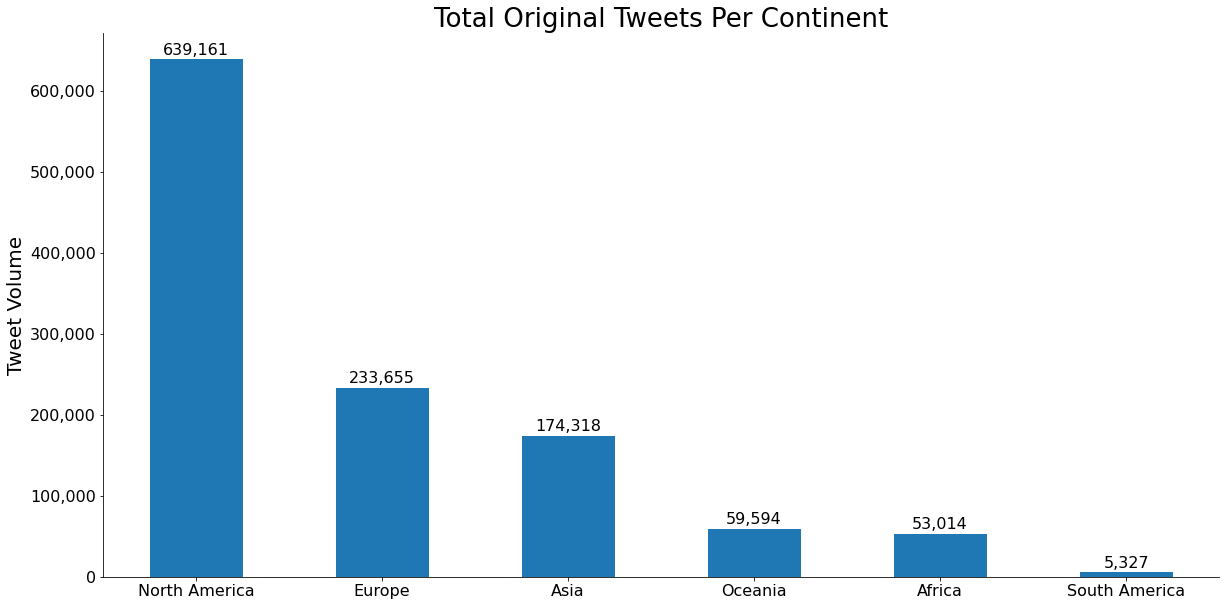

In [52]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

tweet_location_o_pd.sort_values(by='count',ascending=False).plot.bar(ax=ax,legend=None)

r_side = ax.spines["right"]
r_side.set_visible(False)
t_side = ax.spines["top"]
t_side.set_visible(False)

ax.tick_params(axis='x', rotation=0)

ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_ylabel("Tweet Volume", fontsize=20)

ax.set_xticklabels(['North America','Europe','Asia','Oceania','Africa','South America'])

ax.set_title('Total Original Tweets Per Continent', fontsize=26)

for p in ax.patches:
       ax.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', fontsize=16,
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])

plt.savefig('./graph7.png',bbox_inches='tight')
plt.show()

In [66]:
tweet_location_joined = tweet_location_pd.merge(tweet_location_o_pd, on="twt_continent")

In [67]:
tweet_location_joined['ratio'] = tweet_location_joined['count_y']/tweet_location_joined['count_x']

In [68]:
tweet_location_joined = tweet_location_joined.drop(['count_x','count_y'],axis=1)

In [69]:
tweet_location_joined = tweet_location_joined.reindex([0,4,2,3,5,1]).set_index('twt_continent')

In [70]:
tweet_location_joined

,ratio
twt_continent,
NA,0.137473
EU,0.112240
AS,0.221212
OC,0.149334
AF,0.160167
SA,0.085082


<ipython-input-90-6b8dd1a441e8>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.2f}'.format(x) for x in plt.gca().get_yticks()])


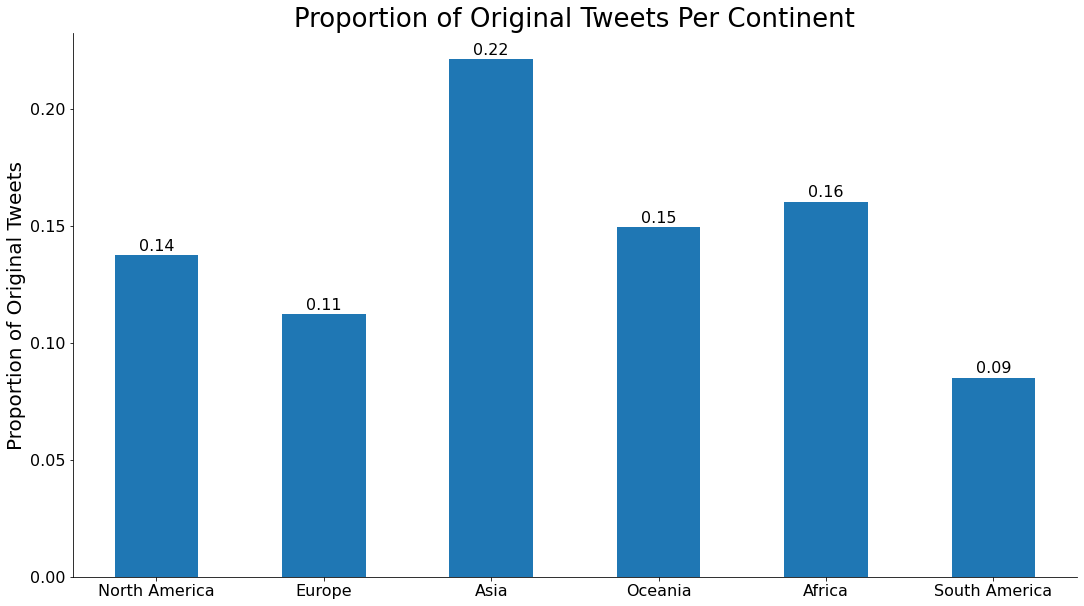

In [90]:
fig, ax = plt.subplots(1,1,figsize=(18,10))

tweet_location_joined.plot.bar(ax=ax,legend=None)

r_side = ax.spines["right"]
r_side.set_visible(False)
t_side = ax.spines["top"]
t_side.set_visible(False)

ax.tick_params(axis='x', rotation=0)

ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_ylabel("Proportion of Original Tweets", fontsize=20)

ax.set_xticklabels(['North America','Europe','Asia','Oceania','Africa','South America'])

ax.set_title('Proportion of Original Tweets Per Continent', fontsize=26)

for p in ax.patches:
       ax.annotate(format(p.get_height(), ',.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', fontsize=16,
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

ax.set_xlabel('')

plt.gca().set_yticklabels(['{:,.2f}'.format(x) for x in plt.gca().get_yticks()])

plt.savefig('./graph8.png',bbox_inches='tight')
plt.show()